In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel(r"C:\Users\USER\Downloads\E Commerce Dataset.xlsx",sheet_name=1)

**Check for duplicate rows** -

In [3]:
df.duplicated().sum()

0

No duplicates

## **Check for Inconsistancies and corruptness**

In [4]:
# Find the unique number of values for each variable
df.nunique()

CustomerID                     5630
Churn                             2
Tenure                           36
PreferredLoginDevice              3
CityTier                          3
WarehouseToHome                  34
PreferredPaymentMode              7
Gender                            2
HourSpendOnApp                    6
NumberOfDeviceRegistered          6
PreferedOrderCat                  6
SatisfactionScore                 5
MaritalStatus                     3
NumberOfAddress                  15
Complain                          2
OrderAmountHikeFromlastYear      16
CouponUsed                       17
OrderCount                       16
DaySinceLastOrder                22
CashbackAmount                 2586
dtype: int64

Except for Customer ID and CashbackAmount, lets find the unique values for the other columns.

In [5]:
# Unique values for columns
for col in df.drop(['CustomerID', 'CashbackAmount'], axis=1).columns:
  print('Column Name :', col)
  print(df[col].unique())
  print('-------------------------------------------------------------')

Column Name : Churn
[1 0]
-------------------------------------------------------------
Column Name : Tenure
[ 4. nan  0. 13. 11.  9. 19. 20. 14.  8. 18.  5.  2. 30.  1. 23.  3. 29.
  6. 26. 28.  7. 24. 25. 10. 15. 22. 27. 16. 12. 21. 17. 50. 60. 31. 51.
 61.]
-------------------------------------------------------------
Column Name : PreferredLoginDevice
['Mobile Phone' 'Phone' 'Computer']
-------------------------------------------------------------
Column Name : CityTier
[3 1 2]
-------------------------------------------------------------
Column Name : WarehouseToHome
[  6.   8.  30.  15.  12.  22.  11.   9.  31.  18.  13.  20.  29.  28.
  26.  14.  nan  10.  27.  17.  23.  33.  19.  35.  24.  16.  25.  32.
  34.   5.  21. 126.   7.  36. 127.]
-------------------------------------------------------------
Column Name : PreferredPaymentMode
['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
-------------------------------------------------------------
Column 

**OBSERVATIONS :** We can observe the following inconsistancies:
- **PreferredLoginDevice** : 'Phone' and 'Mobile' probably indicates mobile phone, since you cannot login with a land phone -> change it to a common 'Mobile'
- **WarehouseToHome** : Has extremely large values like 126 and 127, which is highly unlikely since people don't usually travel that long distance to buy goods. The values might be mistakenly entered -> change 126->26 and 127->27
- **PreferredPaymentMode** :
  - 'CC' and 'Credit Card' indicate credit card -> change it to 'CC'
  - 'Cash on Delivery' and 'COD' indicate cash on delivery -> change it to 'COD'
  - In addition, change Debit Card to DC for convenience.
- **PreferedOrderCat**:
  - 'Mobile' and 'Mobile Phone' -> change it to 'Mobile'
  - 'Laptop & Accessory' -> change it to 'Laptop' for convenience.
- **NumberOfAddress** : Has large numbers above 10, which seems very unlikely. Need to look into it.

In [6]:
# Correct values of column PreferredLoginDevice, WarehouseToHome, PreferredPaymentMode and PreferedOrderCat
df['PreferredLoginDevice'].replace({'Mobile Phone':'Mobile', 'Phone':'Mobile'}, inplace=True)
df['WarehouseToHome'].replace({126:26, 127:27}, inplace=True)
df['PreferredPaymentMode'].replace({'Credit Card':'CC', 'Cash on Delivery':'COD', 'Debit Card':'DC' }, inplace=True)
df['PreferedOrderCat'].replace({'Mobile Phone':'Mobile', 'Laptop & Accessory':'Laptop'}, inplace=True)

Now lets delve into the problem with the inconsistant values of NumberOfAddress.

In [7]:
# Number of rows with NumberOfAddress greater than 5
df[df.NumberOfAddress>5].shape[0]

1453

There seems to be 1453 customers with more than 5 addresses registered in the ecommerce platform, in their name. This seems very unlikely. But we cannot rule out the following possibilities:
- The customer might have multiple properties(houses) in their name.
- Slight change in the address text.
- Addresses of workplace/workplaces if the customer works shifts.
- Ordering for someone else
- Someone else must be ordering in the customer's name name(either other family member with the customer's knowledge or in the rare case fraud transactions by outsiders).

In the above mention cases, multiple addresses might be added.

If we have some other information like the actual list of addresses registered or the locations where the orders were made, number of family members, number of children, occupation related information, annual income etc., we might get a little bit insight into the possibility of customers have multiple addresses.

However, since we do not have them, we need to explore with the available information and reach a conclusion. We shall analyse more in the EDA process and come to a conclusion.

In [8]:
df.isna().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [9]:
# Find columns with missing values
missing_cols = [col for col in df.columns if df[col].isnull().any()]
missing_cols

['Tenure',
 'WarehouseToHome',
 'HourSpendOnApp',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder']

In [10]:
# Find the % of missing value in the above list of columns
percent = df[missing_cols].isnull().sum() * 100/len(df)
missing_df = pd.DataFrame({'column':missing_cols,
                           'no. of missing values' : df[missing_cols].isnull().sum().values,
                           'percentage' : percent.values})
missing_df

,column,no. of missing values,percentage
0,Tenure,264,4.689165
1,WarehouseToHome,251,4.458259
2,HourSpendOnApp,255,4.529307
3,OrderAmountHikeFromlastYear,265,4.706927
4,CouponUsed,256,4.547069
5,OrderCount,258,4.582593
6,DaySinceLastOrder,307,5.452931


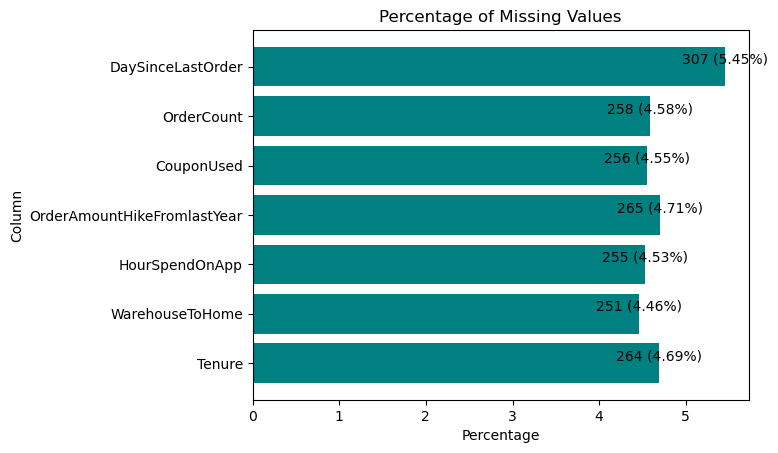

In [11]:
# Create a barh chart
plt.barh(missing_df['column'], missing_df['percentage'], color='#008080')

# Add text labels to each bar
for i in range(len(missing_df)):
    plt.text(missing_df['percentage'].iloc[i], missing_df['column'].iloc[i],
              f"{missing_df['no. of missing values'].iloc[i]} ({missing_df['percentage'].iloc[i]:.2f}%)",
              ha='center', va='bottom')

plt.title('Percentage of Missing Values')
plt.xlabel('Percentage')
plt.ylabel('Column')
plt.show()

- We see that the percent of missing values for any column is below 6%. We can either drop them (columnwise/rowwise) or impute them using any suitable method or a combination of both.
​
- Dropping the column is not recommended, since each column has a max of only 6% missing values.
​
- Lets look at the number of missing values in each row. If any rows has 4 or more than 4 missing values, we shall drop those rows.

In [12]:
# Calculate the number of missing values in each row and finding the count
df.isnull().sum(axis=1).value_counts()

0    3774
1    1856
dtype: int64

The maximum number of missing value in any given row is 1. So, its difficult to drop rows with losing substantial information from the data. Therefore we shall impute them.

In our case, all our missing data are numeric type. Therefore, we shall fill the missing values with mean or median of the variable, depending in the skewness value.

In [13]:
# Calculate skewness of missing value columns
df[missing_cols].skew(axis=0, skipna=True, numeric_only=True)

Tenure                         0.736513
WarehouseToHome                0.898406
HourSpendOnApp                -0.027213
OrderAmountHikeFromlastYear    0.790785
CouponUsed                     2.545653
OrderCount                     2.196414
DaySinceLastOrder              1.191000
dtype: float64

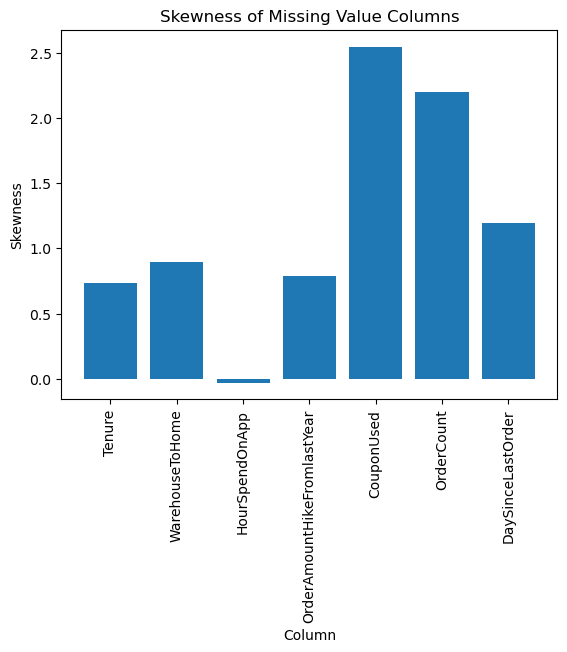

In [14]:
# Calculate the skewness of the missing value columns
skewness = df[missing_cols].skew(axis=0, skipna=True, numeric_only=True)

# Create a bar plot of the skewness
plt.bar(skewness.index, skewness.values)
# Rotate the x ticks by 90 degrees
plt.xticks(skewness.index, skewness.index, rotation=90)
# Add a title and labels to the axes
plt.title('Skewness of Missing Value Columns')
plt.xlabel('Column')
plt.ylabel('Skewness')

# Show the plot
plt.show()

We can see that
- **HourSpendOnApp** is normally distributed -> Fill missing values with mean
- **Tenure and OrderAmountHikeFromlastYear** are moderately skewed -> Fill missing values with mean
- **WarehouseToHome, CouponUsed, OrderCount and DaySinceLastOrder** are highly skewed -> Fill missing values with median

In [15]:
round(df.HourSpendOnApp.mean()), round(df.Tenure.mean()), round(df.OrderAmountHikeFromlastYear.mean()), round(df.WarehouseToHome.mean())

(3, 10, 16, 16)

In [16]:
df.CouponUsed.median(), df.OrderCount.median(), df.DaySinceLastOrder.median()

(1.0, 2.0, 3.0)

In [17]:
# Fill missing values ith mean and median
df.fillna({'HourSpendOnApp':round(df.HourSpendOnApp.mean()),
           'Tenure':round(df.Tenure.mean()),
           'OrderAmountHikeFromlastYear':round(df.OrderAmountHikeFromlastYear.mean()),
           'WarehouseToHome':round(df.WarehouseToHome.mean()),
           'CouponUsed':df.CouponUsed.median(),
           'OrderCount':df.OrderCount.median(),
           'DaySinceLastOrder':df.DaySinceLastOrder.median()}, inplace=True)

In [18]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile,3,6.0,DC,Female,3.0,3,Laptop,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,10.0,Mobile,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,10.0,Mobile,1,30.0,DC,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Mobile,3,15.0,DC,Male,2.0,4,Laptop,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Mobile,1,12.0,CC,Male,3.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [19]:
df.isna().sum()

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

### Outlier Handling

Quantile-based flooring and capping is a technique for removing outliers from data by replacing values that fall below a certain percentile (flooring) or above a certain percentile (capping) with the value of that percentile.

**Tenure**

According to the percentile distribution of 'Tenure', we observe that customers with Tenure > 21, have not churned and the 99th percentile value is 31 which means the extreme values lies after that. So lets cap at the value 31, ie, all values above 31 will be considered as 31.

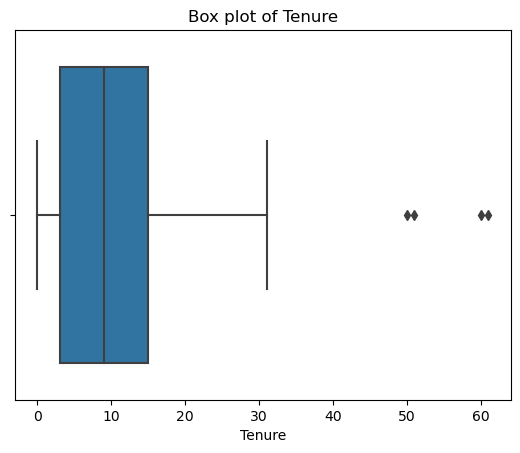

In [20]:
sns.boxplot(data=df, x='Tenure')
plt.title('Box plot of Tenure')
plt.xlabel('Tenure')
plt.show()

In [21]:
percentile = df.Tenure.quantile([0.99]).values
df['Tenure'] = df['Tenure'].apply(lambda x : percentile[0] if x > percentile[0] else x)

**DaySinceLastOrder**

Similarly for DaySinceLastOrder, according to the percentile distribution, we see that values after DaySinceLastOrder=18 are extreme values [30,31,46]. The 99th percentile values is 15. So we shall cap at this position.

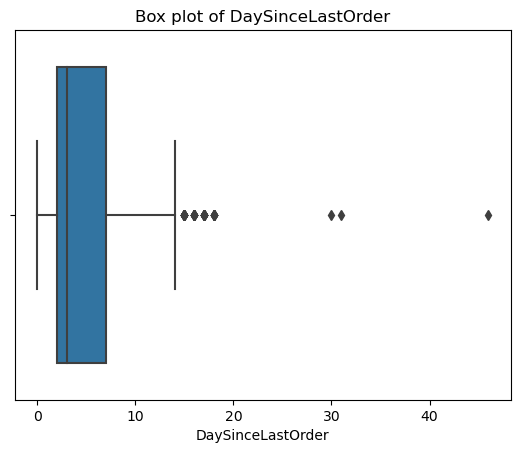

In [22]:
sns.boxplot(data=df, x='DaySinceLastOrder')
plt.title('Box plot of DaySinceLastOrder')
plt.xlabel('DaySinceLastOrder')
plt.show()

In [23]:
percentile = df.DaySinceLastOrder.quantile([0.99]).values
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].apply(lambda x : percentile[0] if x > percentile[0] else x)

**CashbackAmount**
Here we see that there are outliers after the upper bound and below the lower bound. We cap the values at the 1st and 99th percentile.


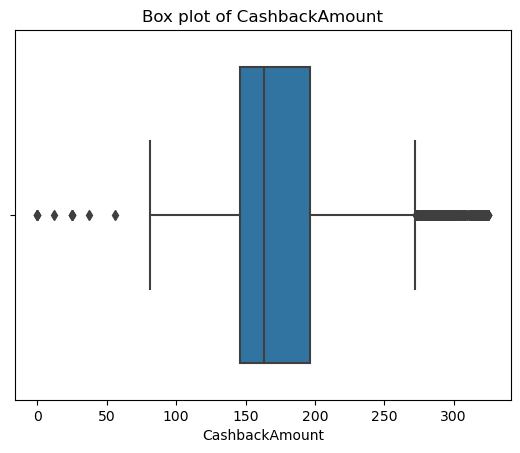

In [24]:
sns.boxplot(data=df, x='CashbackAmount')
plt.title('Box plot of CashbackAmount')
plt.xlabel('CashbackAmount')
plt.show()

In [25]:
percentile = df.CashbackAmount.quantile([0.01, 0.99]).values
df['CashbackAmount'] = df['CashbackAmount'].apply(lambda x : percentile[0] if x < percentile[0] else percentile[1] if x > percentile[1] else x)

Feature engineering add a new feature

In [26]:
# Generating new features from cashback amount divided order count
df['avg_cashbk_per_order'] = df['CashbackAmount'] / df['OrderCount']

Feature selection

In [27]:
# Checking for prediction power of each numerical variables
df[['Churn','Tenure','CityTier','NumberOfDeviceRegistered',
            'SatisfactionScore', 'NumberOfAddress', 'CashbackAmount'
             ,'WarehouseToHome', 'HourSpendOnApp','OrderAmountHikeFromlastYear',
               'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'avg_cashbk_per_order']].groupby(['Churn']).mean()

,Tenure,CityTier,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,CashbackAmount,WarehouseToHome,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,avg_cashbk_per_order
Churn,,,,,,,,,,,,,
0,11.411363,1.619821,3.639257,3.001282,4.162965,180.855946,15.334259,2.928663,15.739641,1.718069,2.992952,4.686672,97.019101
1,3.945148,1.827004,3.934599,3.390295,4.466245,160.428142,17.033755,2.964135,15.632911,1.710970,2.808017,3.189873,88.837215


In [28]:
# Function to perform statistical test on numerical variables to determine whether to reject or accept H0
def num_stats(num_col):
  group_0 = df[df['Churn']==0][num_col]
  group_1 = df[df['Churn']==1][num_col]

  _, p_value = stats.ttest_ind(group_0,group_1,equal_var=False)

  print('P-value : ', p_value)
  if(p_value<0.05):
    print('Reject null hypothesis')
  else:
    print('Do not reject null hypotheis')

function that can be used to perform a statistical test on two numerical variables. The function takes in a numerical column as input and then performs a t-test on the two groups of data, where the groups are defined by the Churn variable. The t-test is a parametric test that is used to compare the means of two groups. The function then prints the p-value of the t-test, which can be used to determine whether to reject or accept the null hypothesis.

The null hypothesis in this case is that the means of the two groups are equal. If the p-value is less than 0.05, then we can reject the null hypothesis and conclude that there is a significant difference between the means of the two groups. Otherwise, we cannot reject the null hypothesis and conclude that there is no significant difference between the means of the two groups.

In [29]:
def chisq_test(cat_col, df):
    CrossTabResult=pd.crosstab(index=df['Churn'], columns=df[cat_col])
    ChiSqResult = chi2_contingency(CrossTabResult)

    # If the ChiSq P-Value is <0.05, that means we reject H0
    if (ChiSqResult[1] < 0.05):
        print('P-Value :', ChiSqResult[1])
        print('Reject null hypothesis')
    else:
        print('P-Value :', ChiSqResult[1])
        print('Do not reject null hypotheis')

function that can be used to perform a chi-squared test on a categorical variable. The function takes in a categorical column as input and then performs a chi-squared test on the two groups of data, where the groups are defined by the Churn variable. The chi-squared test is a non-parametric test that is used to compare the distributions of two categorical variables. The function then prints the p-value of the chi-squared test, which can be used to determine whether to reject or accept the null hypothesis.

The null hypothesis in this case is that the two categorical variables are independent. If the p-value is less than 0.05, then we can reject the null hypothesis and conclude that there is a significant relationship between the two categorical variables. Otherwise, we cannot reject the null hypothesis and conclude that there is no significant relationship between the two categorical variables.


In [30]:
num_col_list = ['Tenure', 'WarehouseToHome', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
                'DaySinceLastOrder', 'CashbackAmount', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress','avg_cashbk_per_order']

In [31]:
for col in num_col_list:
  print('Column Name : ', col)
  num_stats(col)
  print('---------------------------------------------')

Column Name :  Tenure
P-value :  2.008277595367716e-202
Reject null hypothesis
---------------------------------------------
Column Name :  WarehouseToHome
P-value :  7.60206018025374e-09
Reject null hypothesis
---------------------------------------------
Column Name :  OrderAmountHikeFromlastYear
P-value :  0.4237779148876236
Do not reject null hypotheis
---------------------------------------------
Column Name :  CouponUsed
P-value :  0.9159384616337447
Do not reject null hypotheis
---------------------------------------------
Column Name :  OrderCount
P-value :  0.06430615371620459
Do not reject null hypotheis
---------------------------------------------
Column Name :  DaySinceLastOrder
P-value :  3.1021436368381747e-39
Reject null hypothesis
---------------------------------------------
Column Name :  CashbackAmount
P-value :  3.03484589898161e-43
Reject null hypothesis
---------------------------------------------
Column Name :  HourSpendOnApp
P-value :  0.14300103213870458
Do n

In [32]:
cat_col_list = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode',
                'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'Gender', 'Complain']

In [33]:
for col in num_col_list:
  print('Column Name : ', col)
  num_stats(col)
  print('---------------------------------------------')

Column Name :  Tenure
P-value :  2.008277595367716e-202
Reject null hypothesis
---------------------------------------------
Column Name :  WarehouseToHome
P-value :  7.60206018025374e-09
Reject null hypothesis
---------------------------------------------
Column Name :  OrderAmountHikeFromlastYear
P-value :  0.4237779148876236
Do not reject null hypotheis
---------------------------------------------
Column Name :  CouponUsed
P-value :  0.9159384616337447
Do not reject null hypotheis
---------------------------------------------
Column Name :  OrderCount
P-value :  0.06430615371620459
Do not reject null hypotheis
---------------------------------------------
Column Name :  DaySinceLastOrder
P-value :  3.1021436368381747e-39
Reject null hypothesis
---------------------------------------------
Column Name :  CashbackAmount
P-value :  3.03484589898161e-43
Reject null hypothesis
---------------------------------------------
Column Name :  HourSpendOnApp
P-value :  0.14300103213870458
Do n

In [34]:
for col in cat_col_list:
  print('Column Name : ', col)
  chisq_test(col, df)
  print('---------------------------------------------')

Column Name :  PreferredLoginDevice
P-Value : 0.0001477040239947965
Reject null hypothesis
---------------------------------------------
Column Name :  CityTier
P-Value : 1.2612000812079956e-09
Reject null hypothesis
---------------------------------------------
Column Name :  PreferredPaymentMode
P-Value : 1.4978570960706217e-10
Reject null hypothesis
---------------------------------------------
Column Name :  PreferedOrderCat
P-Value : 3.11924340428766e-61
Reject null hypothesis
---------------------------------------------
Column Name :  SatisfactionScore
P-Value : 2.4233349782737515e-14
Reject null hypothesis
---------------------------------------------
Column Name :  MaritalStatus
P-Value : 1.073011277910542e-41
Reject null hypothesis
---------------------------------------------
Column Name :  Gender
P-Value : 0.030820940334890086
Reject null hypothesis
---------------------------------------------
Column Name :  Complain
P-Value : 2.6644609654641377e-78
Reject null hypothesis


In [35]:
df.drop(columns=['CustomerID', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount'], axis=1, inplace=True)

## Feature Encoding

### Label Encoding

In [36]:
le =LabelEncoder()
df['Gender'] =le.fit_transform(df['Gender'])
df['MaritalStatus'] =le.fit_transform(df['MaritalStatus'])
df['PreferredLoginDevice'] =le.fit_transform(df['PreferredLoginDevice'])

### One Hot Encoding

In [37]:
cat=['PreferredPaymentMode','PreferedOrderCat']

In [38]:
df_encoded= pd.get_dummies(df,columns=cat)
df_encoded.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,Gender,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,...,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_DC,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop,PreferedOrderCat_Mobile,PreferedOrderCat_Others
0,1,4.0,1,3,6.0,0,3,2,2,9,...,0,0,1,0,0,0,0,1,0,0
1,1,10.0,1,1,8.0,1,4,3,2,7,...,0,0,0,0,1,0,0,0,1,0
2,1,10.0,1,1,30.0,1,4,3,2,6,...,0,0,1,0,0,0,0,0,1,0
3,1,0.0,1,3,15.0,1,4,5,2,8,...,0,0,1,0,0,0,0,1,0,0
4,1,0.0,1,1,12.0,1,3,5,2,3,...,1,0,0,0,0,0,0,0,1,0


### ***Handling imbalance***

In [39]:
df_encoded.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'Gender', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain',
       'DaySinceLastOrder', 'CashbackAmount', 'avg_cashbk_per_order',
       'PreferredPaymentMode_CC', 'PreferredPaymentMode_COD',
       'PreferredPaymentMode_DC', 'PreferredPaymentMode_E wallet',
       'PreferredPaymentMode_UPI', 'PreferedOrderCat_Fashion',
       'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop',
       'PreferedOrderCat_Mobile', 'PreferedOrderCat_Others'],
      dtype='object')

In [41]:
# Separate dependent and independent variables
X = df_encoded.drop('Churn', axis=1)
y= df_encoded.Churn

In [42]:
#Random oversampling:


from imblearn.over_sampling import RandomOverSampler

# Initialize random oversampler
ros = RandomOverSampler()

# Fit and transform the data
X_resampled, y_resampled = ros.fit_resample(X, y)


In [43]:
#Combine balanced X and y
df_encoded = pd.DataFrame(X_resampled, columns=df_encoded.drop('Churn', axis=1).columns)
df_encoded['Churn'] = y_resampled

df_encoded.head()

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,Gender,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,...,PreferredPaymentMode_COD,PreferredPaymentMode_DC,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop,PreferedOrderCat_Mobile,PreferedOrderCat_Others,Churn
0,4.0,1,3,6.0,0,3,2,2,9,1,...,0,1,0,0,0,0,1,0,0,1
1,10.0,1,1,8.0,1,4,3,2,7,1,...,0,0,0,1,0,0,0,1,0,1
2,10.0,1,1,30.0,1,4,3,2,6,1,...,0,1,0,0,0,0,0,1,0,1
3,0.0,1,3,15.0,1,4,5,2,8,0,...,0,1,0,0,0,0,1,0,0,1
4,0.0,1,1,12.0,1,3,5,2,3,0,...,0,0,0,0,0,0,0,1,0,1


In [44]:
df_encoded.Churn.value_counts()

1    4682
0    4682
Name: Churn, dtype: int64

In [45]:
df_encoded.to_csv('encoded.csv', index = True)